In [242]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [243]:
dftrain = pd.read_csv("/kaggle/input/titanic/train.csv", index_col=0, dtype={"Cabin":"string", "Embarked": "string"})
# FIXME: tf.data.Dataset.from_tensor_slices raises error with some columns
dftrain = dftrain.drop(columns=["Cabin", "Embarked"]).dropna()
y_train = dftrain.pop("Survived")

dftest = pd.read_csv("/kaggle/input/titanic/test.csv", index_col=0)

In [ ]:
# DEBUG ONLY
# Use gender_submission as testing value
dfsubm = pd.read_csv("/kaggle/input/titanic/gender_submission.csv", index_col=0)
dfeval = dftest.join(dfsubm)
# FIXME: tf.data.Dataset.from_tensor_slices raises error with some columns
dfeval = dfeval.drop(columns=["Cabin", "Embarked"]).dropna()
y_eval = dfeval.pop("Survived")

In [244]:
dftrain.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare
PassengerId,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500


In [245]:
y_train.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

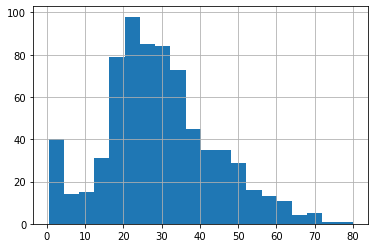

In [246]:
dftrain.Age.hist(bins=20)

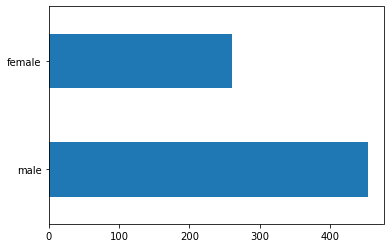

In [247]:
dftrain.Sex.value_counts().plot(kind='barh')

In [248]:
# dftrain["Embarked"].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

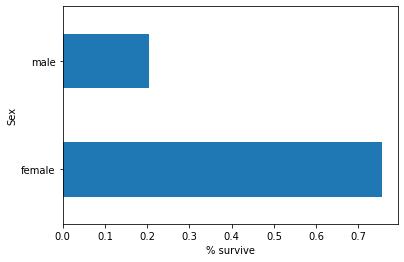

In [249]:
pd.concat([dftrain, y_train], axis=1).groupby('Sex').Survived.mean().plot(kind='barh').set_xlabel('% survive')

In [250]:
# CATEGORY_COLUMNS = ["Sex", "Cabin", "Embarked"]
CATEGORY_COLUMNS = ["Sex"]
NUMERIC_CULUMNS = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

feature_columns = []

for feature_name in CATEGORY_COLUMNS:
    vocabulary = dftrain[column].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_CULUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))


In [251]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [252]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['Fare'])
  print()
  print('A batch of Labels:', label_batch)

Some feature keys: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare']

A batch of class: tf.Tensor(
[  8.6625   7.25    56.9292  76.7292  26.3875 106.425   83.1583  34.375
   7.25    10.4625], shape=(10,), dtype=float64)

A batch of Labels: tf.Tensor([0 0 1 1 1 1 1 0 0 0], shape=(10,), dtype=int64)


In [253]:
feature_columns


[VocabularyListCategoricalColumn(key='Sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 NumericColumn(key='Pclass', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SibSp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [254]:
age_column = feature_columns[2]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[33.],
       [22.],
       [49.],
       [49.],
       [36.],
       [30.],
       [24.],
       [16.],
       [21.],
       [ 2.]], dtype=float32)

In [256]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

print(result)

{'accuracy': 0.9123867, 'accuracy_baseline': 0.6163142, 'auc': 0.9378377, 'auc_precision_recall': 0.8373767, 'average_loss': 0.38197783, 'label/mean': 0.3836858, 'loss': 0.39360636, 'precision': 0.8356164, 'prediction/mean': 0.43758386, 'recall': 0.96062994, 'global_step': 230}


In [290]:
test_input_fn = lambda: tf.data.Dataset.from_tensor_slices(dict(dftest.drop(columns=["Cabin", "Embarked"]))).batch(32)
result = linear_est.predict(test_input_fn)

predictions = []
for i in result:
    predictions.append(i)


    
i = 0
passenger_id_list = []
survived_list = []
for df_index, row in dftest.iterrows():
    passenger_id_list.append(df_index)
    survived_list.append(int(predictions[i]["classes"][0]))
    
    i += 1

d = {'PassengerId': passenger_id_list, 'Survived': survived_list}
df = pd.DataFrame(data=d)
df.to_csv("out.csv", index=False)